In [75]:
! pip install surprise 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
! pip install cosine-similarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
from sklearn.metrics import mean_squared_error
from math import sqrt

from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate

# Import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
from sklearn.metrics import mean_squared_error
from math import sqrt

from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate




In [78]:
! wget https://grouplens.org/datasets/movielens/1m/

--2023-03-27 01:43:17--  https://grouplens.org/datasets/movielens/1m/
Resolving grouplens.org (grouplens.org)... 128.101.34.235
Connecting to grouplens.org (grouplens.org)|128.101.34.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html.1’

index.html.1            [ <=>                ]  13.98K  --.-KB/s    in 0.06s   

2023-03-27 01:43:18 (241 KB/s) - ‘index.html.1’ saved [14320]



In [79]:
#! unzip ml-1m.zip

In [80]:
from google.colab import files
data_to_load = files.upload()

Saving movies.dat to movies (1).dat
Saving ratings.dat to ratings (1).dat
Saving README to README (1)
Saving users.dat to users (1).dat


In [81]:
u_cols = ['user_id', 'Gender', 'age', 'occupation', 'zip_code']
users = pd.read_csv('users.dat', sep='::', names=u_cols,encoding='latin-1')

<ipython-input-81-0956191be088>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv('users.dat', sep='::', names=u_cols,encoding='latin-1')


In [82]:
print("\nUser Data :")
print("shape : ", users.shape)
print(users.head())


User Data :
shape :  (6040, 5)
   user_id Gender  age  occupation zip_code
0        1      F    1          10    48067
1        2      M   56          16    70072
2        3      M   25          15    55117
3        4      M   45           7    02460
4        5      M   25          20    55455


In [83]:
users.head()

,user_id,Gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [84]:
# Reading rating file 
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ratings.dat', sep='::', names=r_cols,encoding='latin-1')

<ipython-input-84-b2756830cf56>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('ratings.dat', sep='::', names=r_cols,encoding='latin-1')


In [85]:
print("\nRatings Data :")
print("shape : ", ratings.shape)
print(ratings.head())


Ratings Data :
shape :  (1000209, 4)
   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


In [86]:
# Reading movies files
i_cols = ['movie_id','Title','Genres']
movies = pd.read_csv('movies.dat', sep='::', names=i_cols,encoding='latin-1')

<ipython-input-86-a7c619a30732>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('movies.dat', sep='::', names=i_cols,encoding='latin-1')


In [87]:
print("\nItem Data :")
print("shape : ", movies.shape)
print(movies.head())


Item Data :
shape :  (3883, 3)
   movie_id                               Title                        Genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy


In [88]:
movies

,movie_id,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


# Popularity Recommender

In [129]:
#split the movies genres
movies[['Genre 1', 'Genre 2', 'Genre 3', 'Genre 4', 'Genre 5', 'Genre 6']] = movies.Genres.str.split("|",expand=True)
movieset = pd.merge(movies, ratings, on = 'movie_id')
movieset.head()


<ipython-input-129-92b523a1cde0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies[['Genre 1', 'Genre 2', 'Genre 3', 'Genre 4', 'Genre 5', 'Genre 6']] = movies.Genres.str.split("|",expand=True)


,movie_id,Title,Genres,metadata,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,Genre 6,user_id,rating,timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,,Animation,Children's,Comedy,None,None,None,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,,Animation,Children's,Comedy,None,None,None,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,,Animation,Children's,Comedy,None,None,None,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,,Animation,Children's,Comedy,None,None,None,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,,Animation,Children's,Comedy,None,None,None,10,5,978226474


In [138]:
def populargenre(movieset, selectedgenre, Genre_1, Genre_2, Genre_3, Genre_4,
                    Genre_5, Genre_6, Title, rating, Num_rating, min_num, top_n):
    moviegenre1 = movieset[movieset[Genre_1] == selectedgenre]
    moviegenre2 = movieset[movieset[Genre_2] == selectedgenre]
    moviegenre3 = movieset[movieset[Genre_3] == selectedgenre]
    moviegenre4 = movieset[movieset[Genre_4] == selectedgenre]
    moviegenre5 = movieset[movieset[Genre_5] == selectedgenre]
    moviegenre6 = movieset[movieset[Genre_6] == selectedgenre]
    moviegenre = pd.concat([moviegenre1, moviegenre2, moviegenre3, moviegenre4, moviegenre5, moviegenre6])
    movieonegenrerating = pd.DataFrame(moviegenre.groupby(Title)[rating].mean())
    movieonegenrerating[Num_rating] = moviegenre.groupby(Title)[rating].count()
    highlyrated_onegenre_movies = movieonegenrerating[movieonegenrerating[Num_rating] > min_num].sort_values(rating, ascending = False).reset_index()
    top_movies = list(highlyrated_onegenre_movies[Title][0:top_n])
    
    return top_movies

genre_list = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Film-Noir",
              "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

allgenres_popular = pd.DataFrame(columns=genre_list)
allgenres_popular.head()

for genre in allgenres_popular.columns:
    allgenres_popular[genre] = populargenre(movieset, genre, 'Genre 1', 'Genre 2', 'Genre 3', 'Genre 4', 'Genre 5', 'Genre 6','Title', 'rating', 'Number of Ratings',70, 10)
    
allgenres_popular.head()


,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Seven Samurai (The Magnificent Seven) (Shichin...,Raiders of the Lost Ark (1981),"Close Shave, A (1995)","Wizard of Oz, The (1939)","Close Shave, A (1995)","Godfather, The (1972)",When We Were Kings (1996),Seven Samurai (The Magnificent Seven) (Shichin...,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Young Frankenstein (1974),Singin' in the Rain (1952),Rear Window (1954),Casablanca (1942),Star Wars: Episode IV - A New Hope (1977),"Close Shave, A (1995)",Schindler's List (1993),Yojimbo (1961)
1,"Godfather, The (1972)",Star Wars: Episode IV - A New Hope (1977),"Wrong Trousers, The (1993)",Toy Story 2 (1999),"Wrong Trousers, The (1993)","Usual Suspects, The (1995)","Thin Blue Line, The (1988)","Shawshank Redemption, The (1994)",Double Indemnity (1944),Psycho (1960),"Wizard of Oz, The (1939)","Third Man, The (1949)",City Lights (1931),Dr. Strangelove or: How I Learned to Stop Worr...,"Usual Suspects, The (1995)",Paths of Glory (1957),Butch Cassidy and the Sundance Kid (1969)
2,Raiders of the Lost Ark (1981),Lawrence of Arabia (1962),Wallace & Gromit: The Best of Aardman Animatio...,Toy Story (1995),Yojimbo (1961),Double Indemnity (1944),Stop Making Sense (1984),"Godfather, The (1972)","Maltese Falcon, The (1941)",Alien (1979),This Is Spinal Tap (1984),"Maltese Falcon, The (1941)","Princess Bride, The (1987)","Matrix, The (1999)",Rear Window (1954),Dr. Strangelove or: How I Learned to Stop Worr...,High Noon (1952)
3,Star Wars: Episode IV - A New Hope (1977),"Great Escape, The (1963)","Grand Day Out, A (1992)","Iron Giant, The (1999)",City Lights (1931),"Godfather: Part II, The (1974)","War Room, The (1993)",Schindler's List (1993),Chinatown (1974),"Shining, The (1980)",Shall We Dance? (1937),Chinatown (1974),"Philadelphia Story, The (1940)",Star Wars: Episode V - The Empire Strikes Back...,"Third Man, The (1949)",Casablanca (1942),"Good, The Bad and The Ugly, The (1966)"
4,"Godfather: Part II, The (1974)",Dersu Uzala (1974),Creature Comforts (1990),Winnie the Pooh and the Blustery Day (1968),"General, The (1927)","Sting, The (1973)",42 Up (1998),Paths of Glory (1957),"Manchurian Candidate, The (1962)",Jaws (1975),My Fair Lady (1964),"Big Sleep, The (1946)",Notorious (1946),Blade Runner (1982),"Sixth Sense, The (1999)",Lawrence of Arabia (1962),Unforgiven (1992)


In [90]:
! pip install cosine-similarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
from sklearn.metrics.pairwise import cosine_similarity

How many unique users?

In [92]:
n_users = ratings.user_id.unique().shape[0]
n_users

6040

How many unique movies?

In [93]:
n_movies = ratings.movie_id.unique().shape[0]
n_movies

3706

Create a User-Movie Matrix

In [94]:
from scipy.sparse import csr_matrix

In [95]:
user_movies_data = ratings.pivot(index = 'movie_id', columns = 'user_id', values = 'rating').fillna(0)

In [96]:
user_movies_data

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2. content filtering 

In [97]:
movies

,movie_id,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [98]:
movies['metadata']= ""

In [99]:
movies

,movie_id,Title,Genres,metadata
0,1,Toy Story (1995),Animation|Children's|Comedy,
1,2,Jumanji (1995),Adventure|Children's|Fantasy,
2,3,Grumpier Old Men (1995),Comedy|Romance,
3,4,Waiting to Exhale (1995),Comedy|Drama,
4,5,Father of the Bride Part II (1995),Comedy,
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,
3879,3949,Requiem for a Dream (2000),Drama,
3880,3950,Tigerland (2000),Drama,
3881,3951,Two Family House (2000),Drama,


In [100]:
movies.Genres, type(movies.Genres)

(0        Animation|Children's|Comedy
 1       Adventure|Children's|Fantasy
 2                     Comedy|Romance
 3                       Comedy|Drama
 4                             Comedy
                     ...             
 3878                          Comedy
 3879                           Drama
 3880                           Drama
 3881                           Drama
 3882                  Drama|Thriller
 Name: Genres, Length: 3883, dtype: object, pandas.core.series.Series)

## TF-IDF Vectorizer on Metadata

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['Genres'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies.index.tolist())
print(tfidf_df.shape)

(3883, 20)


In [102]:
from matplotlib import pyplot as plt

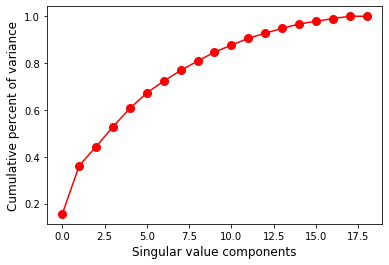

In [103]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=19)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [104]:
n = 20
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=movies.Title.tolist())

In [105]:
latent_matrix_1_df.shape

(3883, 19)

In [111]:
 movies = movies.head(user_movies_data.shape[0])


3.Collaborative Filtering 

In [112]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(user_movies_data)
latent_matrix_2_df = pd.DataFrame(
                             latent_matrix_2, index=movies.Title.tolist())

In [113]:
latent_matrix_2_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),132.784373,-14.058038,-17.340275,2.518697,55.508155,7.595662,-0.035543,7.419393,-5.080133,-27.910461,...,0.209708,3.735532,0.706122,-1.997826,3.807987,3.450998,-3.535275,-8.046279,4.381948,-1.363295
Jumanji (1995),44.573399,-20.000973,5.857215,-16.107409,4.262058,-2.169591,-13.422494,1.170189,4.537864,-8.881406,...,-1.240295,1.467027,-0.269330,-2.427875,2.619389,0.725510,5.908041,-3.266477,-0.797057,1.890132
Grumpier Old Men (1995),26.061632,-11.214055,-7.227290,-14.062228,2.594796,2.326935,-2.418638,6.495406,-1.922108,0.955060,...,3.539237,-0.429586,-1.304863,-1.680418,-2.400153,-1.104516,-0.651885,-4.624371,-1.085170,1.549288
Waiting to Exhale (1995),10.078310,-1.989030,-7.102705,-7.808539,-1.168943,0.549981,-2.255725,-2.012778,1.381027,1.046467,...,0.863880,-0.579059,0.598701,-0.690423,-0.274974,-0.208442,-0.574699,-0.834068,-1.170906,0.262332
Father of the Bride Part II (1995),18.395406,-9.055474,-7.171111,-14.964850,1.917957,3.063568,-1.961754,4.847973,-1.605678,-0.106717,...,-0.188283,-0.124758,1.828823,-2.628717,0.505749,1.942238,-1.589073,-1.502821,-2.217494,-0.287479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dreamscape (1984),47.975035,-8.135795,-22.778547,8.547096,5.335573,-3.448149,-8.520963,10.735109,-3.917179,7.980568,...,3.410960,1.405290,0.082181,0.203801,-9.068632,-2.363001,6.339911,1.540406,-1.412791,-2.164658
"Golden Voyage of Sinbad, The (1974)",24.457903,3.746270,-12.838007,7.045934,-6.276301,-11.966487,-7.286284,-0.539988,2.006432,1.040308,...,-1.745334,1.231009,-1.228249,0.658348,1.882304,1.235820,1.677480,1.492837,-1.535479,0.264244
Hatchet For the Honeymoon (Rosso Segno Della Follia) (1969),4.951244,1.258366,-1.025073,0.189323,-2.343650,-1.504852,-2.011101,0.402278,0.464819,0.813354,...,0.349519,1.352578,-0.352616,-0.281607,0.070380,0.555011,1.491062,1.116258,-0.395599,-0.397102
House Party (1990),2.208159,1.520669,-2.024009,0.574609,-0.385178,-1.108706,-2.178415,-0.500714,0.047734,1.301534,...,-0.509363,0.734686,-0.245864,-0.344770,-0.229847,-0.499401,0.306588,0.388247,0.344038,0.465306


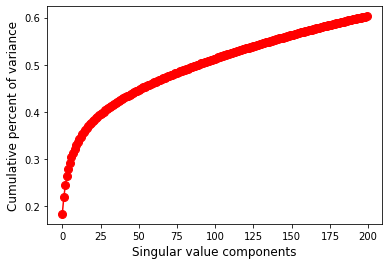

In [114]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [115]:
 from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
# dictDf = {'collaborative': score_2} 
similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Chicken Run (2000),1.000000,0.239965,0.619983
Aladdin and the King of Thieves (1996),1.000000,0.433009,0.716504
Toy Story 2 (1999),1.000000,0.417780,0.708890
"American Tail, An (1986)",1.000000,0.310002,0.655001
"American Tail: Fievel Goes West, An (1991)",1.000000,0.327599,0.663799
Saludos Amigos (1943),1.000000,0.385804,0.692902
"Rugrats Movie, The (1998)",1.000000,0.429698,0.714849
"Adventures of Rocky and Bullwinkle, The (2000)",1.000000,0.192071,0.596035
"Bug's Life, A (1998)",1.000000,0.188993,0.594497
"Road to El Dorado, The (2000)",0.938841,-0.009764,0.464539


In [116]:
similar.sort_values('collaborative', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
"Hour of the Pig, The (1993)",7.372575e-17,0.701863,0.350931
"Bad Seed, The (1956)",1.908196e-17,0.701213,0.350607
Tie Me Up! Tie Me Down! (1990),2.714571e-17,0.650869,0.325435
"Natural, The (1984)",2.714571e-17,0.646709,0.323354
Higher Learning (1995),2.714571e-17,0.644801,0.322401
Rounders (1998),-1.457168e-16,0.634859,0.317430
"Brady Bunch Movie, The (1995)",3.443507e-01,0.619552,0.481951
It Could Happen to You (1994),-9.194034e-17,0.605488,0.302744
Star Wars: Episode V - The Empire Strikes Back (1980),-2.259477e-16,0.600709,0.300355
Babe (1995),6.275573e-01,0.598224,0.612891


In [117]:
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Mulan (1998),0.938841,0.494625,0.716733
Aladdin and the King of Thieves (1996),1.000000,0.433009,0.716504
"Rugrats Movie, The (1998)",1.000000,0.429698,0.714849
Toy Story 2 (1999),1.000000,0.417780,0.708890
"Tigger Movie, The (2000)",0.938841,0.476139,0.707490
"Black Cauldron, The (1985)",0.938841,0.461587,0.700214
Saludos Amigos (1943),1.000000,0.385804,0.692902
Thumbelina (1994),0.938841,0.428698,0.683770
"Fox and the Hound, The (1981)",0.938841,0.413172,0.676007
"American Tail: Fievel Goes West, An (1991)",1.000000,0.327599,0.663799


 Hybrid Recommendation System

In [118]:
def recommend_similar_movies(title):
    # take the latent vectors for a selected movie from both content 
    # and collaborative matrixes
    a_1 = np.array(latent_matrix_1_df.loc[title]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[title]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # an average measure of both content and collaborative 
    hybrid = ((score_1 + score_2)/2.0)

    # form a data frame of similar movies 
    dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

    #sort it on the basis of either: content, collaborative or hybrid
    similar.sort_values('hybrid', ascending=False, inplace=True)

    print(similar[1:].head(11))

In [119]:
recommend_similar_movies("Toy Story (1995)")

                                             content  collaborative    hybrid
Mulan (1998)                                0.938841       0.494625  0.716733
Aladdin and the King of Thieves (1996)      1.000000       0.433009  0.716504
Rugrats Movie, The (1998)                   1.000000       0.429698  0.714849
Toy Story 2 (1999)                          1.000000       0.417780  0.708890
Tigger Movie, The (2000)                    0.938841       0.476139  0.707490
Black Cauldron, The (1985)                  0.938841       0.461587  0.700214
Saludos Amigos (1943)                       1.000000       0.385804  0.692902
Thumbelina (1994)                           0.938841       0.428698  0.683770
Fox and the Hound, The (1981)               0.938841       0.413172  0.676007
American Tail: Fievel Goes West, An (1991)  1.000000       0.327599  0.663799
King and I, The (1999)                      0.938841       0.377308  0.658075


In [120]:
recommend_similar_movies("GoldenEye (1995)")

                                            content  collaborative    hybrid
Indiana Jones and the Last Crusade (1989)  0.839030       0.797158  0.818094
Rock, The (1996)                           1.000000       0.502557  0.751278
Mortal Kombat (1995)                       0.839030       0.628909  0.733969
Hard Target (1993)                         0.821565       0.640771  0.731168
Runaway Train (1985)                       0.948322       0.497522  0.722922
Spawn (1997)                               0.738053       0.696578  0.717315
Clear and Present Danger (1994)            1.000000       0.431531  0.715765
Anaconda (1997)                            1.000000       0.401871  0.700936
Lord of the Flies (1963)                   0.782013       0.604784  0.693398
Firestorm (1998)                           1.000000       0.350449  0.675225
Fled (1996)                                0.839030       0.503782  0.671406


In [121]:
recommend_similar_movies("Mission: Impossible (1996)")

                                              content  collaborative    hybrid
Good Man in Africa, A (1994)                 0.717154       0.506957  0.612056
Highlander (1986)                            0.717154       0.370857  0.544005
Before and After (1996)                      0.644737       0.437307  0.541022
Fallen (1998)                                0.730547       0.340861  0.535704
Young Sherlock Holmes (1985)                 1.000000       0.062848  0.531424
Son of the Sheik, The (1926)                 0.548761       0.512084  0.530423
Knockout (1999)                              0.717154       0.312000  0.514577
Thin Man, The (1934)                         0.696915       0.331975  0.514445
Chain Reaction (1996)                        0.601713       0.421036  0.511375
Indiana Jones and the Temple of Doom (1984)  0.717154       0.290289  0.503721
Metro (1997)                                 0.461704       0.538045  0.499874
